# mmVelo Tutorial in 10x Multiome Embryonic Mouse Brain Dataset

mmVelo is a deep generative model designed to estimate cell state-dependent dynamics across multiple modalities. By utilizing splicing kinetics and multimodal representation learning, mmVelo infers cell state dynamics on joint representations and estimates temporal changes in specific modalities by mapping these dynamics.

This tutorial showcases the application of mmVelo to the [10x Multiome embryonic mouse brain dataset](https://www.10xgenomics.com/datasets/fresh-embryonic-e-18-mouse-brain-5-k-1-standard-2-0-0). Preprocessed 10x Multiome data, stored in the `data` folder, is used for this demonstration. Details of the preprocessing steps can be found in the Methods section of our paper.ble in the Methods section of our paper.



## Train mmVelo and Save Results

You can train mmVelo using the following code:

In [27]:
!python ./src/train.py --experiment 'multiome_mouse_brain' --runpath "tutorial"

Output will be saved in experiments/multiome_mouse_brain/tutorial
loading DataModule...
Loading data...
RNA dim : 3072 ATAC dim : 25071
# cells :3735
RNA library size log-mean, log-std;  7.9308214 0.5958296
ATAC library size log-mean, log-std;  7.8842015 1.028864
loading Models...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
start training for cell state inference.
Missing logger folder: experiments/multiome_mouse_brain/tutorial/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params
---------------------------------------------
0 | vaes       | ModuleList    | 15.7 M
1 | _pz_params | ParameterList | 20    
2 | _pd_params | ParameterList | 20    
---------------------------------------------
15.8 M    Trainable params
20        Non-trainable params
15.8 M    Total params
63.053    Total estimated model params size (MB)
Epoch 0:  88%|█████████▋ | 

## Load the Results

The model's output is stored in `adata_est_rna.h5ad` and `adata_est_atac.h5ad`. 
Below is a description of the elements contained in the adata objects:
- `adata_rna.obsm['latent']`: The inferred cell state
- `adata_rna.obsm['dynamics']`: The inferred cell state-dependent dynamics in cell state space
- `adata_rna.layers['dsdt']`: The inferred RNA velocity
- `adata_atac.layers['dadt']`: The inferred chromatin velocity

Additional Information:
- `adata_rna.layers['Ms']`, `adata_rna.layers['Mu']`, `adata_atac.layers['Ma']`: The observed smoothed counts for spliced mRNA, unspliced mRNA, and chromatin accessibility, respectively
- `adata_rna.layers['s_raw']`, `adata_rna.layers['u_raw']`, `adata_atac.layers['a_raw']`: The reconstructed smoothed counts

In [28]:
import scanpy as sc
dir_path = './experiments/multiome_mouse_brain' + "/" + "tutorial" # './experiments/EXPERIMENT/RUNPATH'
adata_rna = sc.read_h5ad(dir_path + "/adata_est_rna.h5ad")
adata_atac = sc.read_h5ad(dir_path + "/adata_est_atac.h5ad")

adata_rna

AnnData object with n_obs × n_vars = 3735 × 3072
    obs: 'obs_names', 'clusters', 'n_counts', 'dsdt_self_transition'
    var: 'var_names', 'gene_count_corr', 'estimated_genes'
    uns: 'clusters_colors', 'dsdt_graph', 'dsdt_graph_neg', 'dsdt_params', 'neighbors'
    obsm: 'X_umap', 'd_var', 'dsdt_umap', 'dynamics', 'latent'
    layers: 'Ms', 'Mu', 'dsdt', 'dsdt_obs', 'matrix', 's_raw', 'spliced', 'spliced_count', 'u_raw', 'unspliced', 'unspliced_count'
    obsp: 'connectivities', 'distances'

In [29]:
adata_atac

AnnData object with n_obs × n_vars = 3735 × 25071
    obs: 'obs_names', 'dadt_self_transition', 'clusters'
    var: 'var_names'
    uns: 'clusters_colors', 'dadt_graph', 'dadt_graph_neg', 'dadt_params', 'log1p', 'neighbors'
    obsm: 'X_umap', 'dadt_umap', 'latent'
    layers: 'Ma', 'a_raw', 'atac_count', 'dadt', 'rec_a'
    obsp: 'connectivities', 'distances'

The model with optimized parameters can be loaded using the following code:

In [30]:
from src.models import DREG_DYN
model = DREG_DYN.load_from_checkpoint(dir_path + "/checkpoint.ckpt",
                    rna_dim=adata_rna.shape[1], atac_dim=adata_atac.shape[1], r_h1_dim=128, r_h2_dim=64, 
                    a_h1_dim=128, a_h2_dim=64, z_dim=10, d_h_dim=64, strict=False
                    )

/home/nomura/miniconda/envs/mmvelo_torch/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:217: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['log_gamma_beta', 'norm_mat_s', 'norm_mat_u', 'norm_mat_a', 'log_gamma_beta_ss', 'filter_idx', 'retain_gene_idx']
  rank_zero_warn(


## Visualizing the inferred velocity

The streamline plots based on the velocity estimated by mmVelo are saved in the `est_velocity` folder.

Streampline plot based on the inferred cell state dependent-dynamics on cell state space


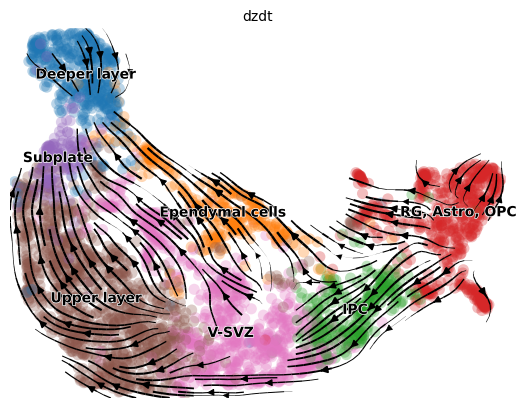

In [31]:
from PIL import Image
image_path = dir_path + "/est_velocity/"

print("Streampline plot based on the inferred cell state dependent-dynamics on cell state space")
Image.open(image_path + "dzdt_streamline_clusters_tanh.png")

Streampline plot based on the inferred RNA velocity


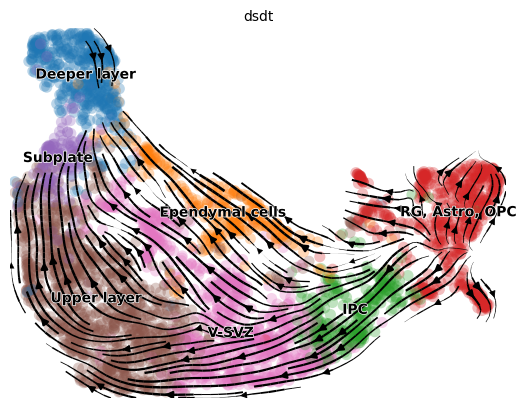

In [32]:
print("Streampline plot based on the inferred RNA velocity")
Image.open(image_path + "dsdt_streamline_clusters_tanh.png")

Streampline plot based on the inferred chromatin velocity


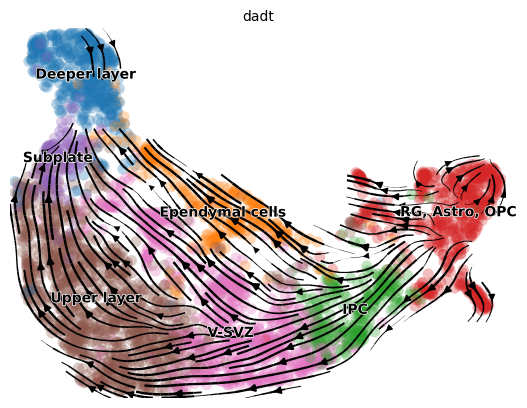

In [33]:
print("Streampline plot based on the inferred chromatin velocity")
Image.open(image_path + "dadt_streamline_clusters_tanh.png")

## Visualizing the chromatin velocity on individual peaks

One of the key innovations of mmVelo is its ability to model chromatin velocity at the single-peak level. 

Here, we demonstrate the visualization of the estimated peak-wise velocity using the Neurod2 promoter region `chr11:98329299–98330151` and enhancer region `chr11:98320243–98320844` as examples.

### Neurod2 promoter (`chr11:98329299-98330151`)

imputed accessibility


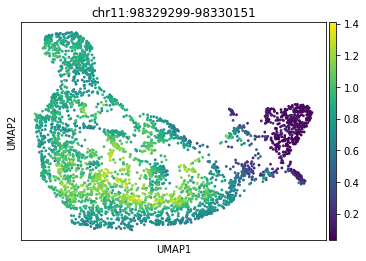

estimated chromatin velocity


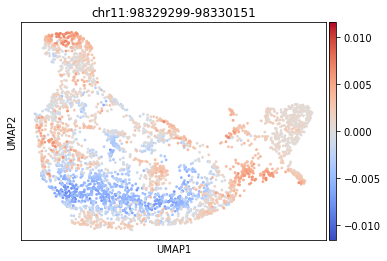

In [34]:
region = "chr11:98329299-98330151"

print("imputed accessibility")
sc.pl.umap(adata_atac, layer="a_raw", color=region, color_map="viridis")

print("estimated chromatin velocity")
vmax = max(abs(adata_atac[:, region].layers["dadt"].reshape(-1)))
sc.pl.umap(adata_atac, layer="dadt", color=region, color_map="coolwarm",
           vmax = vmax, vmin = -vmax)

## Neurod2 enhancer (`chr11:98320243-98320844`)

imputed accessibility


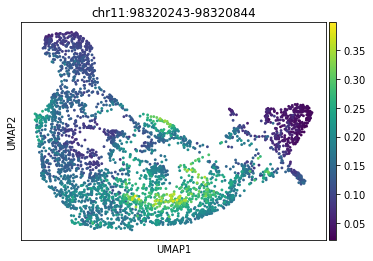

estimated chromatin velocity


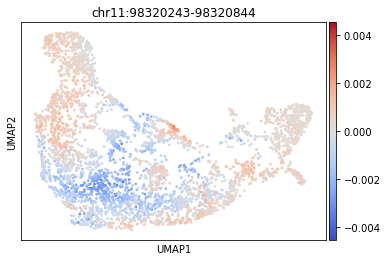

In [35]:
region = "chr11:98320243-98320844"

print("imputed accessibility")
sc.pl.umap(adata_atac, layer="a_raw", color=region, color_map="viridis")

print("estimated chromatin velocity")
vmax = max(abs(adata_atac[:, region].layers["dadt"].reshape(-1)))
sc.pl.umap(adata_atac, layer="dadt", color=region, color_map="coolwarm",
           vmax = vmax, vmin = -vmax)